In [18]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import qutip as qt
import scipy as sp
from scipy import linalg
import matplotlib
import matplotlib.pylab as plt
import krotov
import os.path
import random
from matplotlib import rc
from cycler import cycler
import time
import pandas as pd
from datetime import date
import itertools
from Ps_library_temp import *
from Hamiltonian_library import *
from config import *
rc('font',**{'family':'serif','serif':['Computer Modern'], 'size':25})
rc('text', usetex=True)

In [13]:
A = qt.Qobj([[1,0],[0,1]])
print(A)
print(A.expm())

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[2.71828183 0.        ]
 [0.         2.71828183]]


In [61]:
system = Ps_system(N_atoms =1,N_points = 200)
rabi0 = 2*np.pi*(240e-3)
chirp = 0#2*np.pi*(20e-3)
detuning = 0#2*np.pi*(250e-3)

direction = 1
pulse_duration = 10

laser_guess = {"label":"laser","order":0,"rabi0" : rabi0, "detuning": detuning,"chirp" : chirp,"pulse_duration" : pulse_duration,"unit_wavevector":direction,"start":0,"end":int(3*pulse_duration),"notch":0}
system.init_pulse(laser_guess)
system.init_pulse_cycle()
system.init_distribution_flattop()
#system.init_MBdistribution()
system.init_states_excited()

laser = system.laserDict[0][1]
system.create_composite(laser)
args = {"chirp":np.asarray(laser.chirp(laser.tlist,None)),
        "wavevector":laser.direction,
        "rabi":np.asarray(laser.rabi(laser.tlist,None)),
        "beating":np.asarray(laser.rabi_beating2(laser.tlist,None)),
        "selector1":laser.selector1,
        "selector2":laser.selector2,
        "tlist":laser.tlist,
        "omega_L0":laser.omega_L0}
system.set_Hamiltonian_MT(args)
#system.set_Hamiltonian_noCMT(args)

velocity_states = qt.Qobj(system.initial_pop)
_1S = qt.basis(system.internal_dims,0)
_2P = qt.basis(system.internal_dims,1)
comp_1S = qt.tensor(velocity_states,_1S)
comp_2P = qt.tensor(velocity_states,_2P)
#print(comp_1S.unit().norm())
initial_state = comp_2P.unit()
#initial_state = (comp_1S + comp_2P).unit()

H = system.H
rate = 1/3
spontaneous_emission_operator = qt.projection(system.internal_dims,0,1)

jump_operator = rate*qt.tensor(qt.qeye(system.N_points),spontaneous_emission_operator)

#result2 = qt.mcsolve(H,tlist=laser.tlist,psi0 = comp_2P.unit(),e_ops = system.e_ops,c_ops=[],progress_bar=True,ntraj=500)
result = qt.mcsolve(H,tlist=laser.tlist,psi0 = initial_state,e_ops = system.e_ops,c_ops=jump_operator,progress_bar=True,ntraj=500)
 

10.0%. Run time:   7.17s. Est. time left: 00:00:01:04
20.0%. Run time:  12.23s. Est. time left: 00:00:00:48
30.0%. Run time:  16.73s. Est. time left: 00:00:00:39
40.0%. Run time:  21.84s. Est. time left: 00:00:00:32
50.0%. Run time:  26.88s. Est. time left: 00:00:00:26
60.0%. Run time:  31.97s. Est. time left: 00:00:00:21
70.0%. Run time:  37.47s. Est. time left: 00:00:00:16
80.0%. Run time:  42.38s. Est. time left: 00:00:00:10
90.0%. Run time:  47.66s. Est. time left: 00:00:00:05
100.0%. Run time:  52.45s. Est. time left: 00:00:00:00
Total run time:  52.73s


P_g = 0.00489474560814648
P_e = 0.00019446879754137864


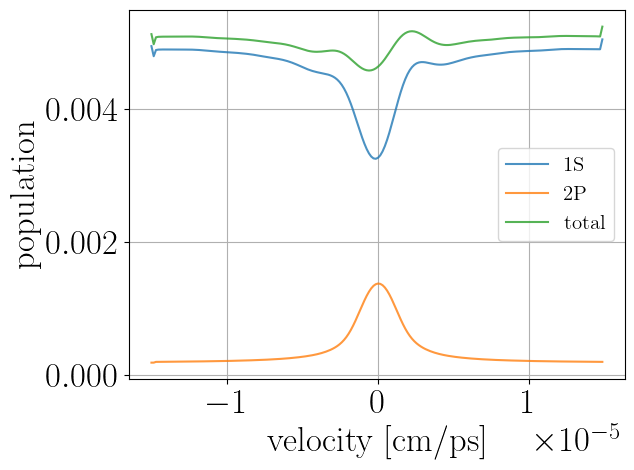

In [65]:
fig,ax = plt.subplots()


print("P_g = {}".format(result.expect[10][-1]))
print("P_e = {}".format(result.expect[210][-1]))

#ax.plot(system.velocity_bins,np.asarray(result.expect)[200:400,0],alpha=0.8,color="black")
#ax.plot(system.velocity_bins,np.asarray(result.expect)[0:200,0],alpha=0.8,color="black")
#print(np.asarray(result.expect)[200:205,0])
#ax.plot(system.velocity_bins,np.asarray(result.expect)[0:200,-1]-np.flip(np.asarray(result.expect)[0:200,-1]),alpha=0.8,label="1S")
#ax.plot(system.velocity_bins,np.asarray(result.expect)[200:400,-1]-np.flip(np.asarray(result.expect)[200:400,-1]),alpha=0.8,label="2P")
ax.plot(system.velocity_bins,np.asarray(result.expect)[0:200,-1],alpha=0.8,label="1S")
ax.plot(system.velocity_bins,np.asarray(result.expect)[200:400,-1],alpha=0.8,label="2P")
ax.plot(system.velocity_bins,np.asarray(result.expect)[200:400,-1]+np.asarray(result.expect)[0:200,-1],alpha=0.8,label="total")
plt.xlabel("velocity [cm/ps]")
plt.ylabel("population")
#plt.vlines(0,0,0.005,ls="dashed",color="black")
plt.grid()
plt.legend(fontsize=15)
plt.title("")
#plt.ylim(0,0.005)
plt.savefig("figures/thesis_draft/high_s_e_CMT.svg",bbox_inches="tight")
plt.show()

detuning in velocity: 0.0
P_g = 4.391034097280221e-10
P_e = 0.004999716127412814


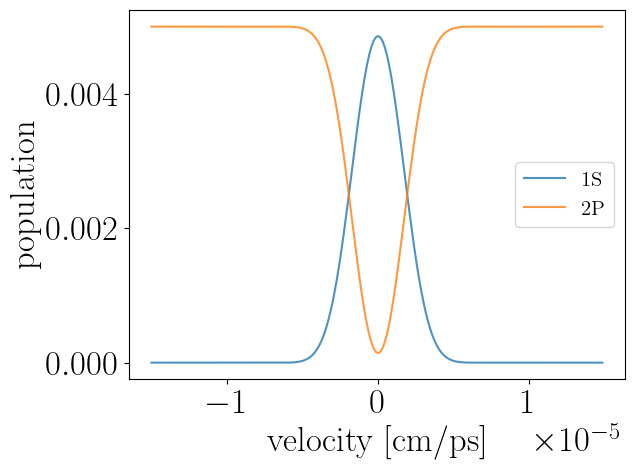

In [23]:
fig,ax = plt.subplots()
print("detuning in velocity: {}".format(detuning*c/omega0))
print("P_g = {}".format(result2.expect[10][-1]))
print("P_e = {}".format(result2.expect[210][-1]))

#ax.plot(system.velocity_bins,np.asarray(result2.expect)[200:400,0],alpha=0.8,color="black")
#ax.plot(system.velocity_bins,np.asarray(result2.expect)[0:200,0],alpha=0.8,color="black")
#print(np.asarray(result.expect)[200:205,0])
#ax.plot(system.velocity_bins,np.asarray(result2.expect)[0:200,-1]-np.flip(np.asarray(result2.expect)[0:200,-1]),alpha=0.8,label="1S")
#ax.plot(system.velocity_bins,np.asarray(result2.expect)[200:400,-1]-np.flip(np.asarray(result2.expect)[200:400,-1]),alpha=0.8,label="2P")
ax.plot(system.velocity_bins,np.asarray(result2.expect)[0:200,-1],alpha=0.8,label="1S")
ax.plot(system.velocity_bins,np.asarray(result2.expect)[200:400,-1],alpha=0.8,label="2P")
#ax.vlines(-detuning*c/omega0,0,0.005,ls="dashed")
plt.xlabel("velocity [cm/ps]")
plt.ylabel("population")
plt.legend(fontsize=15)
plt.title("")
#plt.savefig("figures/feb_2023/dissipation.jpg")
plt.show()

Text(0.5, 1.0, 'This is with no chirp')

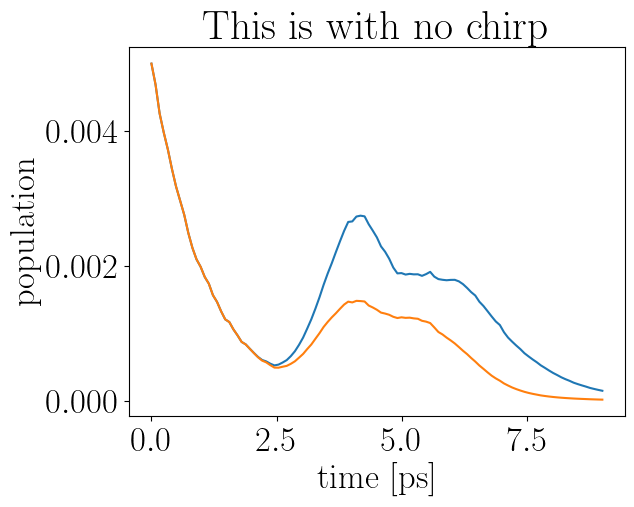

In [102]:
decay = np.asarray([np.exp(-t*rate) for t in laser.tlist])
plt.plot(laser.tlist,np.asarray(result.expect)[320])
plt.plot(laser.tlist,np.asarray(result.expect)[350])
plt.xlabel("time [ps]")
plt.ylabel("population")
plt.title("This is with no chirp")

Text(0, 0.5, 'population')

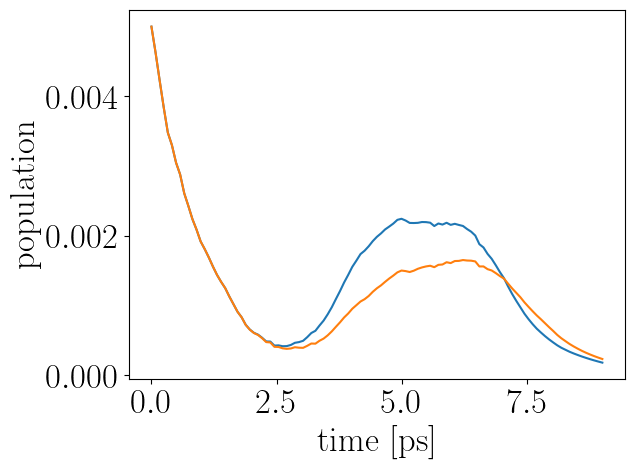

In [98]:
decay = np.asarray([np.exp(-t*rate) for t in laser.tlist])
plt.plot(laser.tlist,np.asarray(result.expect)[320])
plt.plot(laser.tlist,np.asarray(result.expect)[350])
plt.xlabel("time [ps]")
plt.ylabel("population")

There is clearly an issue with the definition of the collapse operators. Let's try to define the Hamiltonian in the lab frame (for just 1 atom, because it's easier), and see if there's a difference

(200,)
10.0%. Run time:  30.44s. Est. time left: 00:00:04:34
20.0%. Run time:  57.27s. Est. time left: 00:00:03:49
30.0%. Run time:  80.72s. Est. time left: 00:00:03:08
40.0%. Run time: 105.00s. Est. time left: 00:00:02:37
50.0%. Run time: 130.06s. Est. time left: 00:00:02:10
60.0%. Run time: 154.78s. Est. time left: 00:00:01:43
70.0%. Run time: 179.03s. Est. time left: 00:00:01:16
80.0%. Run time: 205.34s. Est. time left: 00:00:00:51
90.0%. Run time: 230.40s. Est. time left: 00:00:00:25
100.0%. Run time: 253.98s. Est. time left: 00:00:00:00
Total run time: 254.04s


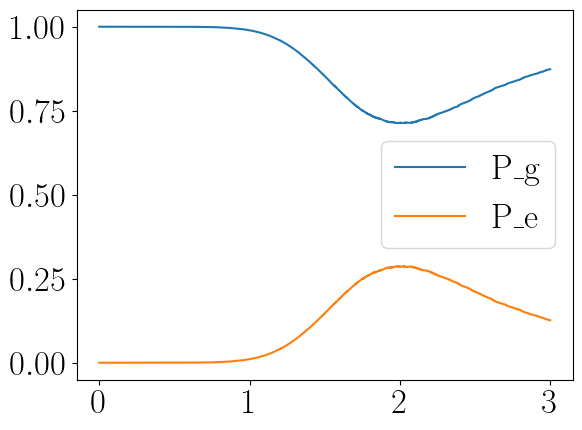

In [22]:
system = Ps_system(N_atoms =1,N_points = 200)
rabi0 = 2*np.pi*(300e-3)
chirp = 2*np.pi*(100e-3)
detuning = 0
direction = 1
pulse_duration = 1

laser_guess = {"scale":0.1, "label":"laser","order":0,"rabi0" : rabi0, "detuning": detuning,"chirp" : chirp,"pulse_duration" : pulse_duration,"unit_wavevector":direction,"start":0,"end":int(3*pulse_duration),"notch":0}
system.init_pulse(laser_guess)
system.init_pulse_cycle()
laser = system.laserDict[0][1]

v = 5e-6
envelope = np.asarray([laser.rabi(t,None) for t in laser.tlist])
phase = np.cos((1+v/c)*(laser.omega_L0-0.5*laser.chirp0*(laser.tlist-laser.tlist_centre))*(laser.tlist-laser.tlist_centre))

H = []
H.append(omega0*qt.Qobj([[0,0],[0,1]]))
H.append([qt.sigmax(),envelope*phase])

kets = [qt.basis(2,i) for i in range(2)]
e_ops = [qt.ket2dm(ket) for ket in kets]
rate = 1/pulse_duration
c_ops = np.sqrt(rate)*qt.projection(2,0,1)
result = qt.mcsolve(H,tlist=laser.tlist,psi0 = kets[0],e_ops = e_ops,c_ops=c_ops,progress_bar=True)
plt.plot(laser.tlist,result.expect[0],label=r"P_g")
plt.plot(laser.tlist,result.expect[1],label=r"P_e")
plt.legend()
plt.show()


10.2%. Run time:   0.00s. Est. time left: 00:00:00:00
20.2%. Run time:   0.00s. Est. time left: 00:00:00:00
30.2%. Run time:   0.00s. Est. time left: 00:00:00:00
40.2%. Run time:   0.01s. Est. time left: 00:00:00:00
50.1%. Run time:   0.01s. Est. time left: 00:00:00:00
60.1%. Run time:   0.01s. Est. time left: 00:00:00:00
70.1%. Run time:   0.01s. Est. time left: 00:00:00:00
80.1%. Run time:   0.01s. Est. time left: 00:00:00:00
90.0%. Run time:   0.02s. Est. time left: 00:00:00:00
Total run time:   0.02s


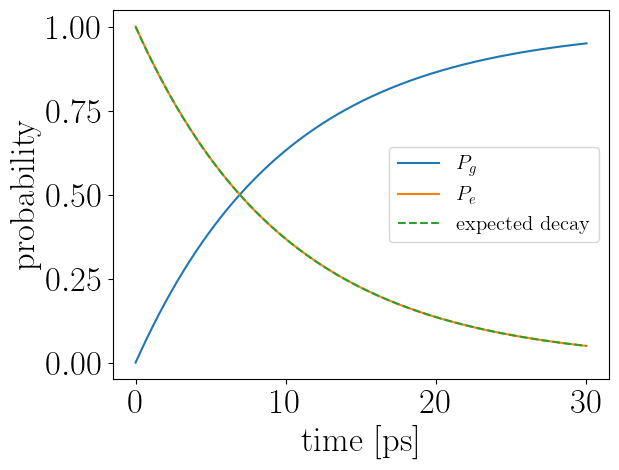

In [84]:
system = Ps_system(N_atoms =1,N_points = 200)
pulse_duration = 10
laser_guess = {"label":"laser","order":0,"rabi0" : 0, "detuning": detuning,"chirp" : 0,"pulse_duration" : pulse_duration,"unit_wavevector":direction,"start":0,"end":int(3*pulse_duration),"notch":0}
system.init_pulse(laser_guess)
system.init_pulse_cycle()
laser = system.laserDict[0][1]

v = 0
envelope = np.asarray([laser.rabi(t,None) for t in laser.tlist])
phase_time_independent = omega0 - (1+v/c)*laser.omega_L0
phase_time_dependent = (1+v/c)*laser.chirp0*(laser.tlist-laser.tlist_centre)

H = []
H.append(phase_time_independent*qt.Qobj([[0,0],[0,1]]))
H.append([qt.Qobj([[0,0],[0,1]]),phase_time_dependent])
H.append([0.5*qt.sigmax(),envelope])

kets = [qt.basis(2,i) for i in range(2)]
e_ops = [qt.ket2dm(ket) for ket in kets]
rate = 1/pulse_duration
c_ops = np.sqrt(rate)*qt.projection(2,0,1)
result = qt.mesolve(H,tlist=laser.tlist,rho0 = kets[1],e_ops = e_ops,c_ops = c_ops,progress_bar=True)

decay = lambda t: np.exp(-t*rate)
plt.plot(laser.tlist,result.expect[0],label=r"$P_g$")
plt.plot(laser.tlist,result.expect[1],label=r"$P_e$")
plt.plot(laser.tlist,decay(laser.tlist),ls="dashed",label="expected decay")
plt.xlabel("time [ps]")
plt.ylabel("population")
plt.legend(fontsize=15)
plt.savefig("figures/thesis_draft/TLS_nolaser.svg",bbox_inches="tight")
plt.show()

In [ ]:

phase = lambda t: omega0 - (1+v/c)*(laser.omega_L0-laser.chirp0*(t-laser.tcentre))
ket_rot = []
ket_lab = []
ket_lab_expect = []
for i in range(len(laser.tlist)):
    t = laser.tlist[i]
    ket_rot.append(qt.Qobj([[result.expect[0][i]],[result.expect[1][i]]]))
    U =  qt.Qobj([[1,0],[0,np.exp(1j*phase(t))]])
    
    ket_lab.append(U.dag()*ket_rot[i])
    P_g = np.abs(np.asarray(ket_lab[i][0])[0][0])
    P_e = np.abs(np.asarray(ket_lab[i][1])[0][0])
    
    
    #P_g = (ket_lab[i].dag()*e_ops[0]*ket_lab[i]).norm()
    #P_e = (ket_lab[i].dag()*e_ops[1]*ket_lab[i]).norm()
    ket_lab_expect.append([P_g,P_e])

plt.title("Rotating frame")
plt.plot(laser.tlist,result.expect[0],label=r"$\psi_-$")
plt.plot(laser.tlist,result.expect[1],label=r"$\psi_+$")
plt.xlabel("time [ps]")
plt.ylabel("probability")
plt.legend()
plt.show()

plt.title("Lab frame")
plt.plot(laser.tlist,np.asarray(ket_lab_expect)[:,0],label=r"P_g")
plt.plot(laser.tlist,np.asarray(ket_lab_expect)[:,1],label=r"P_e")
plt.xlabel("time [ps]")
plt.ylabel("probability")
plt.legend()
plt.show()

plt.title("difference")
plt.plot(laser.tlist,result.expect[0]-np.asarray(ket_lab_expect)[:,0],label=r"P_g")
plt.plot(laser.tlist,result.expect[1]-np.asarray(ket_lab_expect)[:,1],label=r"P_e")
plt.xlabel("time [ps]")
plt.ylabel("probability")
plt.legend()
plt.show()

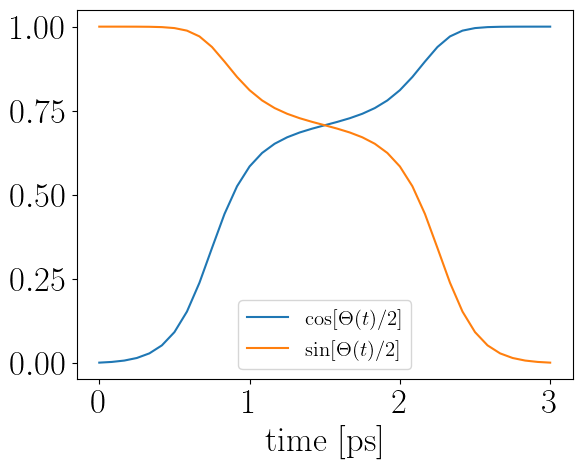

In [17]:
theta = lambda t: np.arccos(phase(t)/np.sqrt(phase(t)**2+np.abs(laser.rabi(t,None))**2))
plt.plot(laser.tlist,np.cos(theta(laser.tlist)/2),label=r"$\cos[\Theta(t)/2]$")
plt.plot(laser.tlist,np.sin(theta(laser.tlist)/2),label=r"$\sin[\Theta(t)/2]$")
plt.xlabel("time [ps]")
plt.legend(fontsize=15)
#plt.savefig("figures/feb_2023/cos_sin_melinger.jpg",bbox_inches="tight")
plt.show()


Test out how deterministic final time population is

In [102]:
system = Ps_system(N_atoms =1,N_points = 200)
rabi0 = 2*np.pi*(1000e-3)
chirp = 2*np.pi*(500e-3)
detuning = 0
direction = -1
pulse_duration = 3
laser_guess = {"label":"laser","order":0,"rabi0" : rabi0, "detuning": detuning,"chirp" : chirp,"pulse_duration" : pulse_duration,"unit_wavevector":direction,"start":0,"end":int(3*pulse_duration),"notch":0}
system.init_pulse(laser_guess)
system.init_pulse_cycle()
laser = system.laserDict[0][1]

ratios = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0]
#ratios = [1]
kets = [qt.basis(2,i) for i in range(2)]
e_ops = [qt.ket2dm(ket) for ket in kets]
v = 0
envelope = np.asarray([laser.rabi(t,None) for t in laser.tlist])
phase_time_independent = omega0 - (1+v/c)*laser.omega_L0
phase_time_dependent = (1+v/c)*laser.chirp0*(laser.tlist-laser.tlist_centre)
H = []
H.append(phase_time_independent*qt.Qobj([[0,0],[0,1]]))
H.append([qt.Qobj([[0,0],[0,1]]),phase_time_dependent])
H.append([0.5*qt.sigmax(),envelope])

results = []
for ratio in ratios:
    initial_state = (ratio*kets[0] + (1-ratio)*kets[1]).unit()
    #print(initial_state)
    result = qt.sesolve(H,tlist=laser.tlist,psi0 = initial_state,e_ops = e_ops,progress_bar=None)
    results.append(result)

(200,)


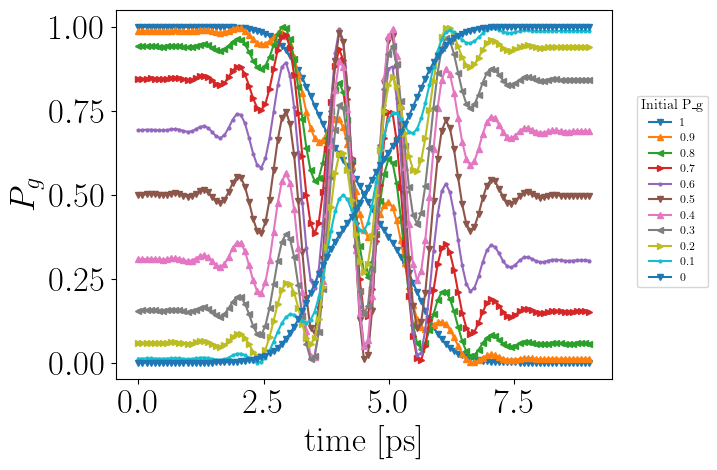

In [87]:
fig,ax = plt.subplots()
marker = itertools.cycle(tuple("v^<>."))
#cycler = plt.cycler(marker="v^<>1234.|",color="rgbrgbrgbr")
for i in range(len(results)):
    ax.plot(laser.tlist,np.asarray(results[i].expect[0]),label=ratios[i],marker=next(marker),markersize=4)

plt.legend(fontsize=8,title="Initial P_g",title_fontsize=10,loc=(1.05,0.25))
plt.ylabel(r"$P_g$")
plt.xlabel("time [ps]")
#plt.savefig("figures/feb_2023/deterministic_arp.jpg",bbox_inches="tight")
plt.show()

In [103]:
print("(P_g_i, P_g_f) vs (P_e_i,P_e_f):")
for result in results:
    P_g_i = result.expect[0][0]
    P_g_f = result.expect[0][-1]
    P_e_i = result.expect[1][0]
    P_e_f = result.expect[1][-1]
    print("({:.2f},{:.2f}) vs ({:.2f},{:.2f})".format(P_g_i,P_g_f,P_e_i,P_e_f))

(P_g_i, P_g_f) vs (P_e_i,P_e_f):
(1.00,0.00) vs (0.00,1.00)
(0.99,0.01) vs (0.01,0.99)
(0.94,0.06) vs (0.06,0.94)
(0.84,0.15) vs (0.16,0.85)
(0.69,0.30) vs (0.31,0.70)
(0.50,0.50) vs (0.50,0.50)
(0.31,0.69) vs (0.69,0.31)
(0.16,0.84) vs (0.84,0.16)
(0.06,0.94) vs (0.94,0.06)
(0.01,0.99) vs (0.99,0.01)
(0.00,1.00) vs (1.00,0.00)


That was for a fully efficient pulse. How about for a pulse that isn't efficient?

In [114]:
system = Ps_system(N_atoms =1,N_points = 200)
rabi0 = 2*np.pi*(300e-3)
chirp = 2*np.pi*(100e-3)
detuning = 0
direction = -1
pulse_duration = 3
laser_guess = {"label":"laser","order":0,"rabi0" : rabi0, "detuning": detuning,"chirp" : chirp,"pulse_duration" : pulse_duration,"unit_wavevector":direction,"start":0,"end":int(3*pulse_duration),"notch":0}
system.init_pulse(laser_guess)
system.init_pulse_cycle()
laser = system.laserDict[0][1]

ratios = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0]
#ratios = [1]
kets = [qt.basis(2,i) for i in range(2)]
e_ops = [qt.ket2dm(ket) for ket in kets]
v = 0
envelope = np.asarray([laser.rabi(t,None) for t in laser.tlist])
phase_time_independent = omega0 - (1+v/c)*laser.omega_L0
phase_time_dependent = (1+v/c)*laser.chirp0*(laser.tlist-laser.tlist_centre)
H = []
H.append(phase_time_independent*qt.Qobj([[0,0],[0,1]]))
H.append([qt.Qobj([[0,0],[0,1]]),phase_time_dependent])
H.append([0.5*qt.sigmax(),envelope])

results = []
for ratio in ratios:
    initial_state = (ratio*kets[0] + (1-ratio)*kets[1]).unit()
    #print(initial_state)
    result = qt.sesolve(H,tlist=laser.tlist,psi0 = initial_state,e_ops = e_ops,progress_bar=None)
    results.append(result)

(200,)


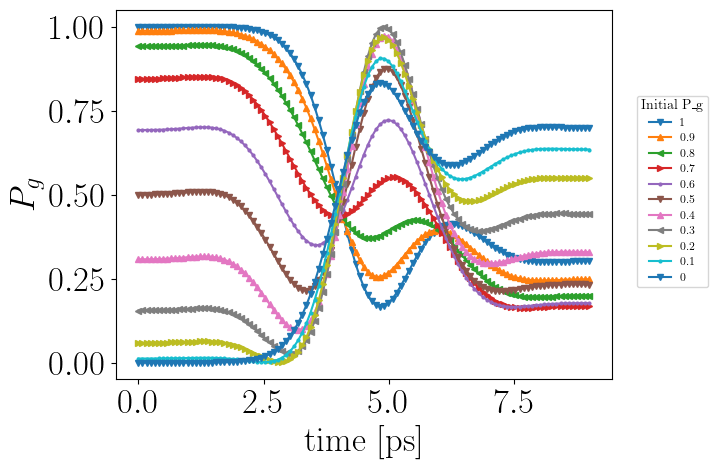

In [96]:
fig,ax = plt.subplots()
marker = itertools.cycle(tuple("v^<>."))
#cycler = plt.cycler(marker="v^<>1234.|",color="rgbrgbrgbr")
for i in range(len(results)):
    ax.plot(laser.tlist,np.asarray(results[i].expect[0]),label=ratios[i],marker=next(marker),markersize=4)

plt.legend(fontsize=8,title="Initial P_g",title_fontsize=10,loc=(1.05,0.25))
plt.ylabel(r"$P_g$")
plt.xlabel("time [ps]")
#plt.savefig("figures/feb_2023/deterministic_arp_inefficient_transfer.jpg",bbox_inches="tight")
plt.show()

In [135]:
print("(P_g_i, P_g_f) vs (P_e_i,P_e_f):")
for result in results:
    P_g_i = result.expect[0][0]
    P_g_f = result.expect[0][-1]
    P_e_i = result.expect[1][0]
    P_e_f = result.expect[1][-1]
    print("({:.2f},{:.2f}) vs ({:.2f},{:.2f})".format(P_g_i,P_g_f,P_e_i,P_e_f))

x = [result.expect[0][0]]
plt.plot()

(P_g_i, P_g_f) vs (P_e_i,P_e_f):
(1.00,0.30) vs (0.00,0.70)
(0.99,0.25) vs (0.01,0.75)
(0.94,0.20) vs (0.06,0.80)
(0.84,0.17) vs (0.16,0.83)
(0.69,0.18) vs (0.31,0.82)
(0.50,0.23) vs (0.50,0.77)
(0.31,0.33) vs (0.69,0.67)
(0.16,0.44) vs (0.84,0.56)
(0.06,0.55) vs (0.94,0.45)
(0.01,0.63) vs (0.99,0.37)
(0.00,0.70) vs (1.00,0.30)


In [144]:
a = 1
print("(P_g_i, P_g_f) vs (P_e_i,P_e_f):")
for result in results:
    P_g_i = result.expect[0][0]
    P_e_i = result.expect[1][0]
    expect_e_f = a*P_g_i + (1-a)*P_e_i
    expect_g_f = a*P_e_i + (1-a)*P_g_i
    print("({:.2f},{:.2f}) : ({:.2f},{:.2f})".format(P_g_i,expect_g_f,P_e_i,expect_e_f))
    

(P_g_i, P_g_f) vs (P_e_i,P_e_f):
(1.00,0.00) : (0.00,1.00)
(0.99,0.01) : (0.01,0.99)
(0.94,0.06) : (0.06,0.94)
(0.84,0.16) : (0.16,0.84)
(0.69,0.31) : (0.31,0.69)
(0.50,0.50) : (0.50,0.50)
(0.31,0.69) : (0.69,0.31)
(0.16,0.84) : (0.84,0.16)
(0.06,0.94) : (0.94,0.06)
(0.01,0.99) : (0.99,0.01)
(0.00,1.00) : (1.00,0.00)


### It seems that the code might actually be working just fine, and that the velocity asymmetry is in fact physical which comes from the very large s.e. rate. Thus, go on to photoionisation and see if that looks fine

In [17]:
system = Ps_system()
rabi0 = 2*np.pi*(500e-3)
chirp = 2*np.pi*(50e-3)
detuning = 0
direction = 1
pulse_duration = 1
system.flag_photoionisation = True

laser_guess = {"label":"laser","order":0,"rabi0" : rabi0, "detuning": detuning,"chirp" : chirp,"pulse_duration" : pulse_duration,"unit_wavevector":direction,"start":0,"end":int(3*pulse_duration),"notch":0}
system.init_pulse(laser_guess)
system.init_pulse_cycle()
laser = system.laserDict[0][1]
system.init_distribution_flattop()
system.create_composite(laser)
system.init_states_excited()


initial_state = system.states
args = {"chirp":np.asarray(laser.chirp(laser.tlist,None)),
        "wavevector":laser.direction,
        "rabi":np.asarray(laser.rabi(laser.tlist,None)),
        "beating":np.asarray(laser.rabi_beating2(laser.tlist,None)),
        "selector1":laser.selector1,
        "selector2":laser.selector2,
        "tlist":laser.tlist,
        "omega_L0":laser.omega_L0}
system.set_Hamiltonian_MT(args)
#system.set_Hamiltonian_noCMT(args)
#print(system.e_ops)
result = qt.mcsolve(system.H,tlist=laser.tlist,psi0 = initial_state,e_ops = system.e_ops,c_ops=system.c_ops,progress_bar=True,ntraj=500)

10.0%. Run time:   5.92s. Est. time left: 00:00:00:53
20.0%. Run time:  11.85s. Est. time left: 00:00:00:47
30.0%. Run time:  17.95s. Est. time left: 00:00:00:41
40.0%. Run time:  24.34s. Est. time left: 00:00:00:36
50.0%. Run time:  31.40s. Est. time left: 00:00:00:31
60.0%. Run time:  37.26s. Est. time left: 00:00:00:24
70.0%. Run time:  43.36s. Est. time left: 00:00:00:18
80.0%. Run time:  50.23s. Est. time left: 00:00:00:12
90.0%. Run time:  56.62s. Est. time left: 00:00:00:06
100.0%. Run time:  63.20s. Est. time left: 00:00:00:00
Total run time:  63.54s


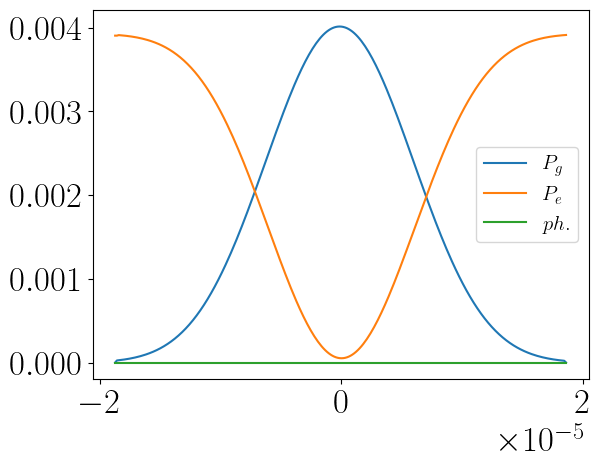

In [16]:
final_states = np.asarray(result.expect)[:,-1]

plt.plot(system.velocity_bins,final_states[250:500],label=r"$P_g$")
plt.plot(system.velocity_bins,final_states[500:750],label=r"$P_e$")
plt.plot(system.velocity_bins,final_states[0:250],label=r"$ph.$")
plt.legend(fontsize=15)
#plt.plot(system.velocity_bins,np.flip(final_states[250:500]),label=r"$P_g$")
#plt.plot(system.velocity_bins,np.flip(final_states[500:750]),label=r"$P_e$")
#plt.plot(system.velocity_bins,np.flip(final_states[0:250]),label=r"$ph.$")
plt.legend(fontsize=15)

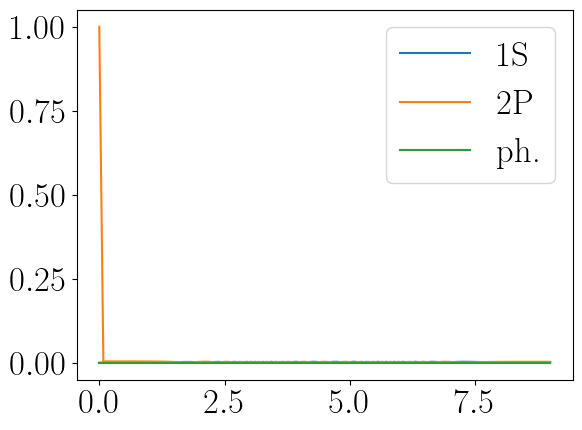

In [30]:
#150th bin
intime_ph = np.asarray(result.expect)[150,:]
intime_1S = np.asarray(result.expect)[400,:]
intime_2P = np.asarray(result.expect)[650,:]



plt.plot(laser.tlist,intime_1S,label="1S")
plt.plot(laser.tlist,intime_2P,label="2P")
plt.plot(laser.tlist,intime_ph,label="ph.")
plt.legend()